<a href="https://colab.research.google.com/github/Kanii34/Python-for-deeplearning/blob/main/ARIMA_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import io
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
#from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install pmdarima
from pmdarima.arima import auto_arima

In [3]:
#드라이브에 접근할 수 있도록 아래 코드 입력
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
train_x = pd.read_csv("/content/drive/MyDrive/대회/Dacon_비트코인/Data&code/train_x_df.csv")
train_y = pd.read_csv("/content/drive/MyDrive/대회/Dacon_비트코인/Data&code/train_y_df.csv")
test_x = pd.read_csv('/content/drive/MyDrive/대회/Dacon_비트코인/Data&code/test_x_df.csv')
sample_submission = pd.read_csv("/content/drive/MyDrive/대회/Dacon_비트코인/Data&code/sample_submission.csv")

In [5]:
train_x.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534


In [6]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [7]:
train_x_arr=df2d_to_array3d(train_x)
train_y_arr=df2d_to_array3d(train_y)
test_x_arr=df2d_to_array3d(test_x)

In [8]:
print(f'''
train_x_arr {train_x_arr.shape}
train_y_arr {train_y_arr.shape}
test_x_arr {test_x_arr.shape}
''')


train_x_arr (7661, 1380, 10)
train_y_arr (7661, 120, 10)
test_x_arr (535, 1380, 10)



In [43]:
import datetime
start_time = '2021-01-31 00:00:00'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

Arima는 sample_id 마다 반복적으로 fitting이 필요함.
반복문 필요.


In [81]:
idx=1120
x_series = train_x_arr[idx,:,1] # 1 = open price
y_series = train_y_arr[idx,:,1]


model=auto_arima(x_series,start_p=0,start_q=0)
print(model.summary())

from statsmodels.tsa.statespace.sarimax import SARIMAX

est_model = SARIMAX(x_series,
                     order=model.order,
                     seasonal_order=model.seasonal_order).fit()
display(est_model.summary())
#preds1=fit.predict(1381,1381+120,typ="levels")

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1380
Model:               SARIMAX(1, 1, 1)   Log Likelihood                7783.593
Date:                Sun, 30 May 2021   AIC                         -15561.185
Time:                        06:17:09   BIC                         -15545.498
Sample:                             0   HQIC                        -15555.316
                               - 1380                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2142      0.062     -3.432      0.001      -0.337      -0.092
ma.L1         -0.1635      0.057     -2.854      0.004      -0.276      -0.051
sigma2      7.301e-07   1.59e-08     45.877      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1380
Model:               SARIMAX(1, 1, 1)   Log Likelihood                7783.593
Date:                Sun, 30 May 2021   AIC                         -15561.185
Time:                        06:17:09   BIC                         -15545.498
Sample:                             0   HQIC                        -15555.316
                               - 1380                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2142      0.062     -3.432      0.001      -0.337      -0.092
ma.L1         -0.1635      0.057     -2.854      0.004      -0.276      -0.051
sigma2      7.301e-07   1.59e-08     45.877      0.000    6.99e-07    7.61e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2987.37
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.43
Prob(H) (two-sided):                  0.91   Kurtosis:                        10.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
print(model.order)
print(model.seasonal_order)

(1, 1, 1)
(0, 0, 0, 0)


In [66]:
print(pred2.mean)

<built-in method mean of numpy.ndarray object at 0x7fb4675baf30>


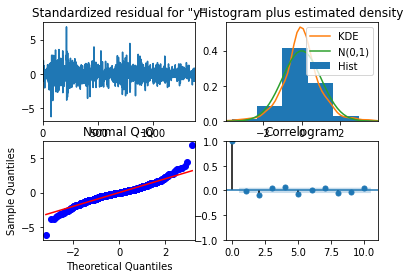

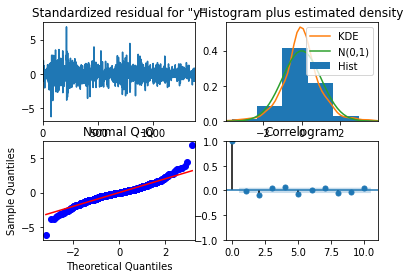

In [51]:
est_model.plot_diagnostics()

In [52]:
preds1= est_model.get_prediction(1381,1380+120)
pred_ci=preds1.conf_int()

preds1.predicted_mean

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [47]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red') # t=1380 은 무조건 1임
    plt.legend()

In [74]:
print(x_series)

[0.98361421 0.98324466 0.98269397 ... 0.99901819 0.99962926 1.        ]


In [78]:
len(np.arange(1380, 1380+120))

pred1=est_model.forecast(steps=120)
print(pred1)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


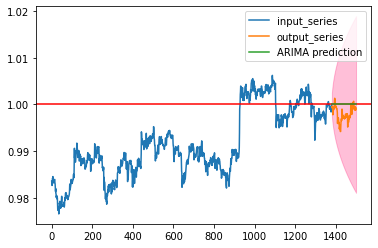

In [79]:
pred1=est_model.forecast(steps=120)

plot_series(x_series, y_series)
#preds1.predicted_mean.plot(ax=ax, label='SARIMAX prediction',alpha=0.7,color='green')
plt.plot(np.arange(1380, 1380+120), pred1, label = 'ARIMA prediction')
plt.fill_between(np.arange(1380, 1380+120),pred_ci[:,0],pred_ci[:,1],color='#ff0066',alpha=.25)

plt.legend()
plt.show()

In [83]:
# 모형이 수렴하지 않는 경우에 대한 대안이 필요함.

test_pred_array=np.zeros([test_x_arr.shape[0],120])

for idx in tqdm(range(test_x_arr.shape[0])):
  x_series=test_x_arr[idx,:,1]
  fit=None
  # Find optimal p,d,q for sample_id :idx by auto_arima
  model=auto_arima(x_series,start_p=0,start_q=0)
  
  try:

    # Fit SARIMAX 
    est_model = SARIMAX(x_series,
                     order=model.order,
                     seasonal_order=model.seasonal_order).fit()
    # forecast
    preds1= est_model.forecast(steps=120)

  except Exception as e :
    est_model = SARIMAX(x_series,order=(1,1,1),seasonal_order=c(0,0,0)).fit()
    preds1= est_model.forecast(steps=120)


  test_pred_array[idx,:] = preds1



  0%|          | 0/535 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


  0%|          | 1/535 [00:06<57:00,  6.41s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


  0%|          | 2/535 [00:08<44:25,  5.00s/it]

  1%|          | 3/535 [00:44<2:07:55, 14.43s/it]

  1%|          | 4/535 [00:46<1:34:02, 10.63s/it]

  1%|          | 5/535 [00:48<1:11:45,  8.12s/it]

  1%|          | 6/535 [00:51<58:55,  6.68s/it]  

  1%|▏         | 7/535 [00:53<46:05,  5.24s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


  1%|▏         | 8/535 [00:58<44:17,  5.04s/it]

  2%|▏     

In [97]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    # 100.1% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    arr1 = (buy_price > 1.001) * 1
    submission.loc[:, 'buy_quantity'] = arr1
    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)

    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    submission.loc[:,'sample_id']=sample_submission.loc[:,'sample_id']
    return submission

In [98]:
submission = array_to_submission(test_x_arr,test_pred_array)


print(submission.buy_quantity.value_counts())
print(submission.head())

0    529
1      6
Name: buy_quantity, dtype: int64
   sample_id  buy_quantity  sell_time
0       7661             0          0
1       7662             0          0
2       7663             1        119
3       7664             0          0
4       7665             0          0


In [96]:
test_pred_array[2,119]

1.021487690121557

In [94]:
submission.to_csv("/content/drive/MyDrive/대회/Dacon_비트코인/Data&code/ARIMA_submission.csv",index=False)